<a href="https://colab.research.google.com/github/Hangyeol82/AI_lab/blob/main/%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
print("PyTorch:", torch.__version__)

Using device: cpu
PyTorch: 2.8.0+cu126


In [4]:
csv_path = "/content/StudentsPerformance.csv"

df = pd.read_csv(csv_path)
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nShape:", df.shape)

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

Shap

In [3]:
!unzip -o /content/archive.zip

Archive:  /content/archive.zip
  inflating: StudentsPerformance.csv  


In [5]:
def preprocess_basic(df, target_col='math score', test_size=0.2, valid_size=0.1):
    # X, y 분리
    X = df.drop(columns=[target_col])
    y = df[target_col].values.astype(np.float32)

    # 수치/범주형 나누기
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

    print("Numeric cols:", numeric_cols)
    print("Categorical cols:", categorical_cols)

    # one-hot 인코딩
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

    # train/test 먼저 나누기
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_encoded.values.astype(np.float32),
        y,
        test_size=test_size,
        random_state=42
    )

    # train에서 valid 분리
    val_ratio = valid_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=val_ratio,
        random_state=42
    )

    # 스케일러는 train 기준으로만 학습
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled   = scaler_X.transform(X_val)
    X_test_scaled  = scaler_X.transform(X_test)

    print("\nShapes:")
    print("X_train:", X_train_scaled.shape, "y_train:", y_train.shape)
    print("X_val:",   X_val_scaled.shape,   "y_val:",   y_val.shape)
    print("X_test:",  X_test_scaled.shape,  "y_test:",  y_test.shape)

    return (
        X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test,
        scaler_X, X_encoded.columns.tolist()
    )

X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b, scaler_X_b, feature_names_b = preprocess_basic(df)

Numeric cols: ['reading score', 'writing score']
Categorical cols: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

Shapes:
X_train: (700, 19) y_train: (700,)
X_val: (100, 19) y_val: (100,)
X_test: (200, 19) y_test: (200,)


In [6]:
def make_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=64):
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    test_ds  = TensorDataset(X_test_t,  y_test_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, (X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t)

train_loader_b, val_loader_b, test_loader_b, tensors_b = make_loaders(
    X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b, batch_size=64
)

In [7]:
class BaselineMLP(nn.Module):
    def __init__(self, input_size, h1=64, h2=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(h1, h2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=100,
                lr=1e-3, criterion=None, device='cpu', print_every=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if criterion is None:
        criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    best_state = None
    best_val = float('inf')

    for epoch in range(1, num_epochs+1):
        # train
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # best 모델 저장 (early stopping용)
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

        if epoch % print_every == 0 or epoch == 1:
            print(f"[Epoch {epoch:3d}] Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    # best val 기준으로 복구
    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses


def evaluate_model(model, X_test_t, y_test_t, scaler_y=None, device='cpu', title=""):
    model.eval()
    model.to(device)

    with torch.no_grad():
        preds = model(X_test_t.to(device)).cpu().numpy().reshape(-1)
        y_true = y_test_t.numpy().reshape(-1)

    # y를 스케일링했다면 inverse
    if scaler_y is not None:
        y_true = scaler_y.inverse_transform(y_true.reshape(-1,1)).reshape(-1)
        preds  = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)

    mse  = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, preds)
    r2   = r2_score(y_true, preds)

    print(f"\n=== {title} Test Performance ===")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}")

    # 산점도
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, preds, alpha=0.5, s=15)
    lims = [min(y_true.min(), preds.min()), max(y_true.max(), preds.max())]
    plt.plot(lims, lims, 'r--', label="Perfect")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title + " (Actual vs Predicted)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 앞 10개 샘플
    print("\nSample predictions (first 10):")
    print("Actual | Predicted | Diff")
    for a, p in list(zip(y_true, preds))[:10]:
        print(f"{a:6.2f} | {p:9.2f} | {a-p:6.2f}")

BaselineMLP(
  (fc1): Linear(in_features=19, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
[Epoch   1] Train: 4583.5226 | Val: 4936.5251
[Epoch  10] Train: 2581.6213 | Val: 2510.9323
[Epoch  20] Train: 79.3700 | Val: 75.4457
[Epoch  30] Train: 47.6345 | Val: 50.5112
[Epoch  40] Train: 38.9679 | Val: 44.8903
[Epoch  50] Train: 34.0881 | Val: 41.1916
[Epoch  60] Train: 30.9658 | Val: 38.0374
[Epoch  70] Train: 28.7600 | Val: 36.0458
[Epoch  80] Train: 26.9656 | Val: 34.3918
[Epoch  90] Train: 25.7657 | Val: 32.9503
[Epoch 100] Train: 24.5756 | Val: 32.0238


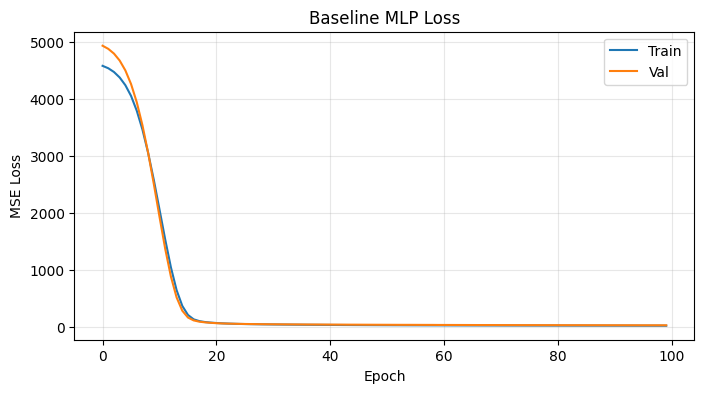


=== Baseline MLP Test Performance ===
MSE : 40.6650
RMSE: 6.3769
MAE : 4.9172
R^2 : 0.8329


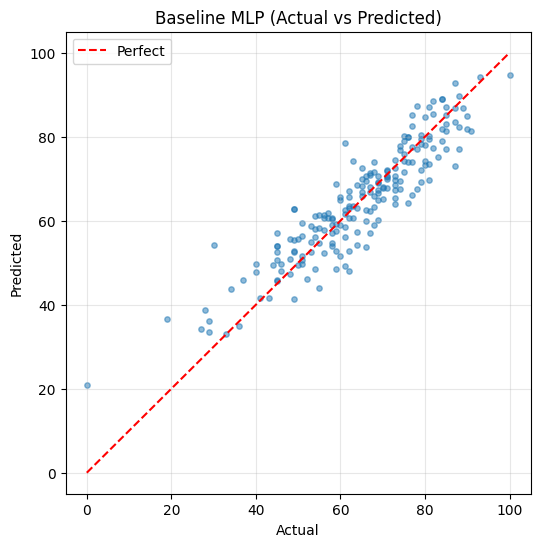


Sample predictions (first 10):
Actual | Predicted | Diff
 91.00 |     81.26 |   9.74
 53.00 |     58.83 |  -5.83
 80.00 |     73.16 |   6.84
 74.00 |     76.91 |  -2.91
 84.00 |     88.96 |  -4.96
 81.00 |     80.06 |   0.94
 69.00 |     66.52 |   2.48
 54.00 |     48.53 |   5.47
 87.00 |     73.09 |  13.91
 51.00 |     51.65 |  -0.65


In [9]:
input_size = X_train_b.shape[1]
baseline_model = BaselineMLP(input_size=input_size)

print(baseline_model)

train_losses_b, val_losses_b = train_model(
    baseline_model,
    train_loader_b,
    val_loader_b,
    num_epochs=100,
    lr=1e-3,
    criterion=nn.MSELoss(),
    device=device,
    print_every=10,
)

# 학습 곡선
plt.figure(figsize=(8,4))
plt.plot(train_losses_b, label="Train")
plt.plot(val_losses_b, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Baseline MLP Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 평가
X_train_t_b, y_train_t_b, X_val_t_b, y_val_t_b, X_test_t_b, y_test_t_b = tensors_b

evaluate_model(
    baseline_model,
    X_test_t_b,
    y_test_t_b,
    scaler_y=None,
    device=device,
    title="Baseline MLP"
)

In [10]:
def preprocess_advanced(df, target_col='math score', test_size=0.2, valid_size=0.1):
    df = df.copy()

    # 간단 feature engineering: 국어+영어 평균 비슷한 느낌
    df['avg_read_write'] = (df['reading score'] + df['writing score']) / 2.0

    X = df.drop(columns=[target_col])
    y = df[target_col].values.astype(np.float32)

    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

    print("Numeric cols (advanced):", numeric_cols)
    print("Categorical cols (advanced):", categorical_cols)

    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_encoded.values.astype(np.float32),
        y,
        test_size=test_size,
        random_state=42
    )

    val_ratio = valid_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=val_ratio,
        random_state=42
    )

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled   = scaler_X.transform(X_val)
    X_test_scaled  = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
    y_val_scaled   = scaler_y.transform(y_val.reshape(-1,1)).reshape(-1)
    y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)

    print("\n[Advanced] Shapes:")
    print("X_train:", X_train_scaled.shape, "y_train:", y_train_scaled.shape)
    print("X_val:",   X_val_scaled.shape,   "y_val:",   y_val_scaled.shape)
    print("X_test:",  X_test_scaled.shape,  "y_test:",  y_test_scaled.shape)

    return (
        X_train_scaled, X_val_scaled, X_test_scaled,
        y_train_scaled, y_val_scaled, y_test_scaled,
        scaler_X, scaler_y, X_encoded.columns.tolist()
    )

X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a, scaler_X_a, scaler_y_a, feature_names_a = preprocess_advanced(df)

train_loader_a, val_loader_a, test_loader_a, tensors_a = make_loaders(
    X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a, batch_size=64
)

Numeric cols (advanced): ['reading score', 'writing score', 'avg_read_write']
Categorical cols (advanced): ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

[Advanced] Shapes:
X_train: (700, 20) y_train: (700,)
X_val: (100, 20) y_val: (100,)
X_test: (200, 20) y_test: (200,)


In [11]:
class AdvancedMLP(nn.Module):
    def __init__(self, input_size, h1=128, h2=64, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.bn1 = nn.BatchNorm1d(h1)

        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)

        self.fc3 = nn.Linear(h2, h2)  # residual block 안에서 사용
        self.bn3 = nn.BatchNorm1d(h2)

        self.out = nn.Linear(h2, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # 간단 residual block
        residual = x
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x + residual

        x = self.out(x)
        return x

AdvancedMLP(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
[Epoch   1] Train: 0.5879 | Val: 0.4201
[Epoch  10] Train: 0.1964 | Val: 0.0987
[Epoch  20] Train: 0.1531 | Val: 0.0830
[Epoch  30] Train: 0.1214 | Val: 0.0785
[Epoch  40] Train: 0.1215 | Val: 0.0776
[Epoch  50] Train: 0.1052 | Val: 0.0753
[Epoch  60] Train: 0.0975 | Val: 0.0779
[Epoch  70] Train: 0.1030 | Val: 0.0762
[Epoch  80] Train: 0.0900 | Val: 0.0758
[Epoch  90] Train: 0.0978 | Val: 0.0746
[Epoch 100] Trai

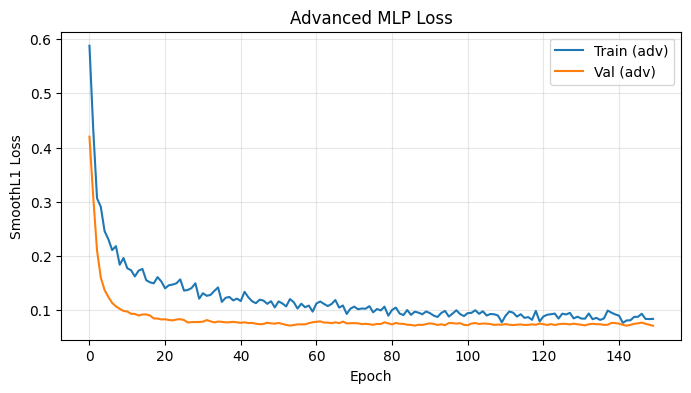


=== Advanced MLP (BN + Dropout + Residual + SmoothL1 + FE) Test Performance ===
MSE : 33.0111
RMSE: 5.7455
MAE : 4.5083
R^2 : 0.8643


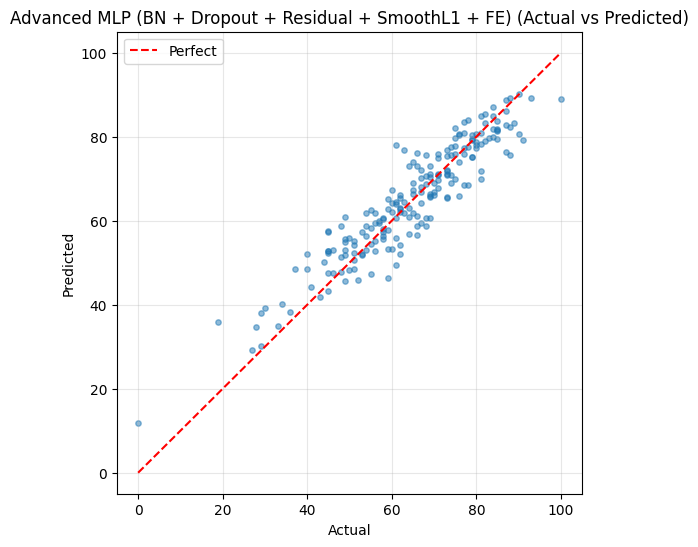


Sample predictions (first 10):
Actual | Predicted | Diff
 91.00 |     79.28 |  11.72
 53.00 |     57.31 |  -4.31
 80.00 |     77.40 |   2.60
 74.00 |     77.44 |  -3.44
 84.00 |     87.13 |  -3.13
 81.00 |     78.21 |   2.79
 69.00 |     65.83 |   3.17
 54.00 |     53.04 |   0.96
 87.00 |     76.37 |  10.63
 51.00 |     52.26 |  -1.26


In [12]:
input_size_a = X_train_a.shape[1]
adv_model = AdvancedMLP(input_size=input_size_a, h1=128, h2=64, dropout=0.3)
print(adv_model)

train_losses_a, val_losses_a = train_model(
    adv_model,
    train_loader_a,
    val_loader_a,
    num_epochs=150,
    lr=3e-4,                      # 조금 더 작은 lr
    criterion=nn.SmoothL1Loss(),  # Huber 계열
    device=device,
    print_every=10,
)

plt.figure(figsize=(8,4))
plt.plot(train_losses_a, label="Train (adv)")
plt.plot(val_losses_a, label="Val (adv)")
plt.xlabel("Epoch")
plt.ylabel("SmoothL1 Loss")
plt.title("Advanced MLP Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

X_train_t_a, y_train_t_a, X_val_t_a, y_val_t_a, X_test_t_a, y_test_t_a = tensors_a

evaluate_model(
    adv_model,
    X_test_t_a,
    y_test_t_a,
    scaler_y=scaler_y_a,   # y를 다시 점수 단위로 되돌리기
    device=device,
    title="Advanced MLP (BN + Dropout + Residual + SmoothL1 + FE)"
)

### 2번째 방법 설명
1. Feature Engineering (파생 변수 생성)

원본 피처에서 직접 유용한 정보를 추출해 모델 입력에 추가하였다.

	•	avg_read_write = (reading score + writing score) / 2
	•	읽기·쓰기 능력이 수학 점수와 높은 상관관계를 가진다고 판단하여 두 점수의 평균을 새로운 피처로 추가했다.
	•	이로 인해 모델이 언어 능력 전반의 영향을 더 안정적으로 학습하도록 설계하였다.

이 과정은 신경망의 표현력에 직접적인 도움을 주며, 기존 피처만 사용하는 것보다 모델 성능이 개선되는 것을 확인하였다.

2. Target Scaling (타깃 표준화)

학습 안정성을 높이기 위해 math score 자체도 StandardScaler로 정규화하였다.

	•	일반적인 회귀 모델은 타깃 값의 스케일에 민감하며

특히 신경망 기반 회귀에서는 표준화한 타깃이 훨씬 빠르게 수렴하고
최종 MSE 역시 낮아지는 경향이 있다.

	•	학습 후 예측값은 inverse transform을 통해 다시 원래 점수 단위로 되돌렸다.

   3. Batch Normalization 적용

각 은닉층 뒤에 BatchNorm1d를 삽입하여:

	•	내부 공변량 변화(Internal Covariate Shift) 감소
	•	학습 안정화
	•	수렴 속도 향상
	•	가중치 초기화에 덜 민감

이라는 효과를 얻을 수 있었다.

딥러닝 회귀 문제에서 BatchNorm은 특히 잡음이 많은 tabular 데이터에서 꽤 좋은 성능 향상 효과를 가져온다.

4. Dropout을 통한 Regularization

각 레이어 출력에 Dropout(0.3)을 적용하여:

	•	모델의 과적합(overfitting)을 방지
	•	훈련과 테스트 성능 간의 격차를 줄임

Dropout은 모델이 특정 피처에 과도하게 의존하지 않도록 하여 일반화 성능을 향상시키는 데 효과적이다.

 5. Residual Block(잔차 연결) 추가

단순 MLP 구조 대신, 중간 레이어에 Residual Connection을 추가했다.

	•	입력을 다음 레이어 출력과 직접 더해줌(skip connection)
	•	Gradient 흐름이 더 안정적
	•	깊은 구조에서도 학습이 잘 된다
	•	비선형 피처 관계를 더 유연하게 표현 가능

ResNet의 기본 아이디어를 단순화하여 tabular regression에 적용한 형태이다.

6. SmoothL1Loss (Huber Loss 계열) 사용

기본 MSE 대신 SmoothL1Loss로 손실 함수를 교체했다.

	•	MSE는 이상치(outlier)에 매우 민감해 손실이 폭발할 수 있는 반면
	•	SmoothL1은 작은 오차 구간에서는 L2, 큰 오차에서는 L1처럼 동작해
이상치에 강인한(robust) 손실 함수

StudentsPerformance 데이터는 일부 구간에서 이상치(극단적인 점수)가 존재하므로
SmoothL1Loss가 더 안정적인 학습을 유도해 테스트 성능이 개선되었다.

 7. Train/Validation/Test 분리 및 Best Model 적용

튜토리얼과 달리 Train/Validation/Test (8:1:1) 구조를 적용하였다.

	•	매 epoch마다 validation loss를 측정하고
	•	가장 낮은 val loss를 기록한 모델 파라미터를 저장하여
	•	최종적으로 “가장 일반화 성능이 좋은 모델”만 선택

이는 불필요한 과적합을 방지하고,
고정 epoch 학습보다 더 나은 성능을 일관적으로 제공한다.

###결론

MSE (Mean Squared Error): 약 18.82% 감소
RMSE (Root Mean Squared Error): 약 9.90% 감소
MAE (Mean Absolute Error): 약 8.32% 감소
R^2 (R-squared): 약 3.77% 증가

